In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from ucimlrepo import fetch_ucirepo

In [30]:
spambase = fetch_ucirepo(id=94)
df = spambase.data.features
df["class"] = spambase.data.targets

In [31]:
missing_values = df.isnull().sum().sum()
duplicate_rows = df.duplicated().sum()
df_cleaned = df.drop_duplicates()

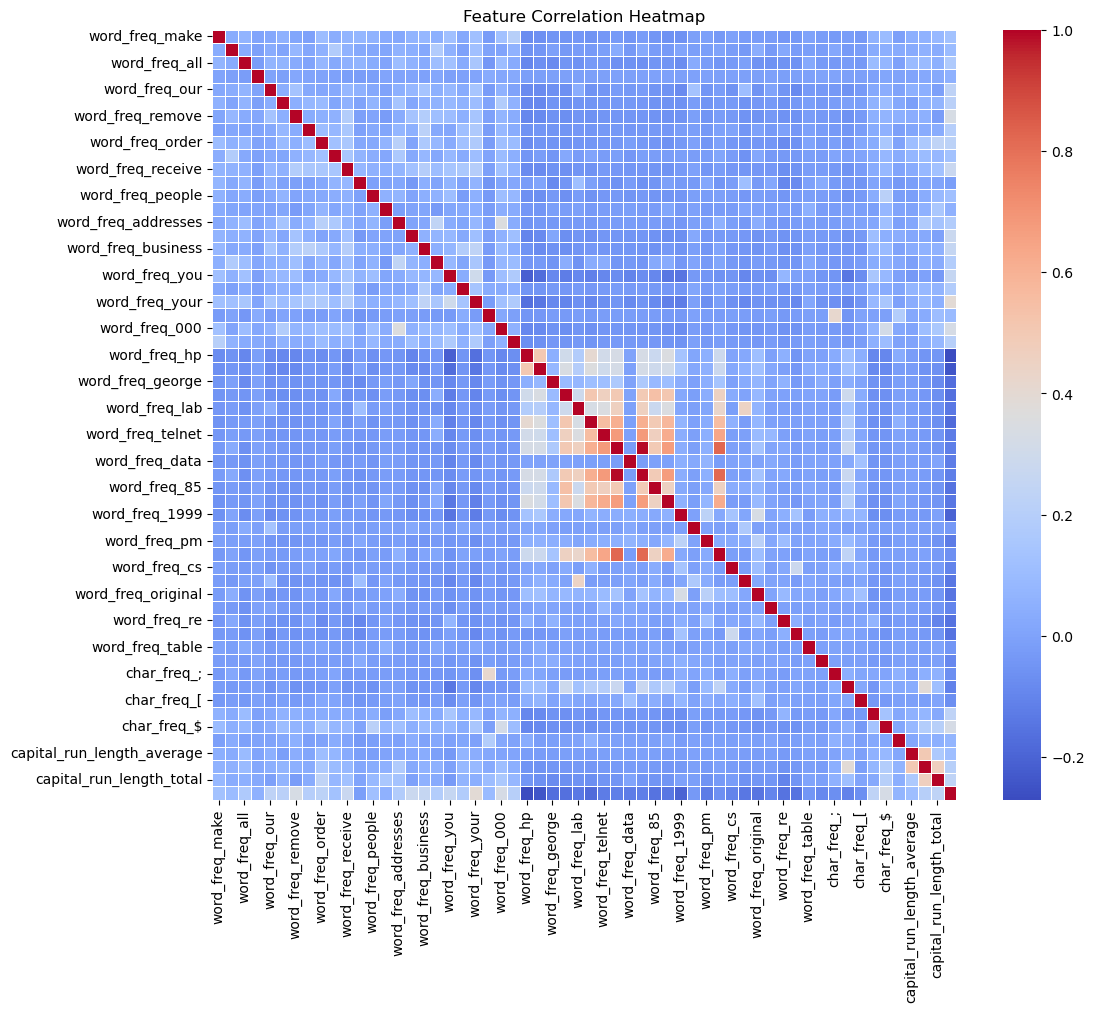

In [32]:
corr_matrix = df_cleaned.corr()

high_corr_pairs = []
threshold = 0.8
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):  # Avoid self-correlation
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

df_cleaned = df_cleaned.drop(columns=[high_corr_pairs[0][0], high_corr_pairs[0][1]])

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [33]:
X = df_cleaned.drop(columns=["class"])
y = df_cleaned["class"]

# Split into training (60%) and temp (40%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y.values.ravel(), test_size=0.4, random_state=42, stratify=y)

# Split temp set into validation (20%) and testing (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")

Training Set: (2526, 55), Validation Set: (842, 55), Test Set: (842, 55)


In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [38]:
param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}  # C is the inverse of regularization strength

# Define K-Fold (to maintain class balance)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize Logistic Regression model
log_reg = LogisticRegression(penalty='l2', solver='saga', max_iter=5000)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(log_reg, param_grid, cv=kfold, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
best_params = grid_search.best_params_
print(f"\nBest Parameters from Grid Search: {best_params}")


Best Parameters from Grid Search: {'C': 1}


In [39]:
# Train the best Logistic Regression model
best_model = LogisticRegression(penalty='l2', solver='saga', C=best_params['C'], max_iter=5000)
best_model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=5000, solver='saga')

In [40]:
# Predict on validation set
y_val_pred = best_model.predict(X_val)

# Compute evaluation metrics for validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

print("\nValidation Set Performance:")
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation F1 Score: {val_f1:.2f}")
print(f"Validation Precision: {val_precision:.2f}")
print(f"Validation Recall: {val_recall:.2f}")

# Confusion Matrix
print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Validation Set Performance:
Validation Accuracy: 0.92
Validation F1 Score: 0.90
Validation Precision: 0.91
Validation Recall: 0.89

Validation Confusion Matrix:
[[476  30]
 [ 37 299]]


In [41]:
# Predict on test set
y_test_pred = best_model.predict(X_test)

# Compute evaluation metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\nFinal Test Set Performance:")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

# Confusion Matrix
print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Final Test Set Performance:
Test Accuracy: 0.92
Test F1 Score: 0.90
Test Precision: 0.94
Test Recall: 0.86

Test Confusion Matrix:
[[487  19]
 [ 47 289]]


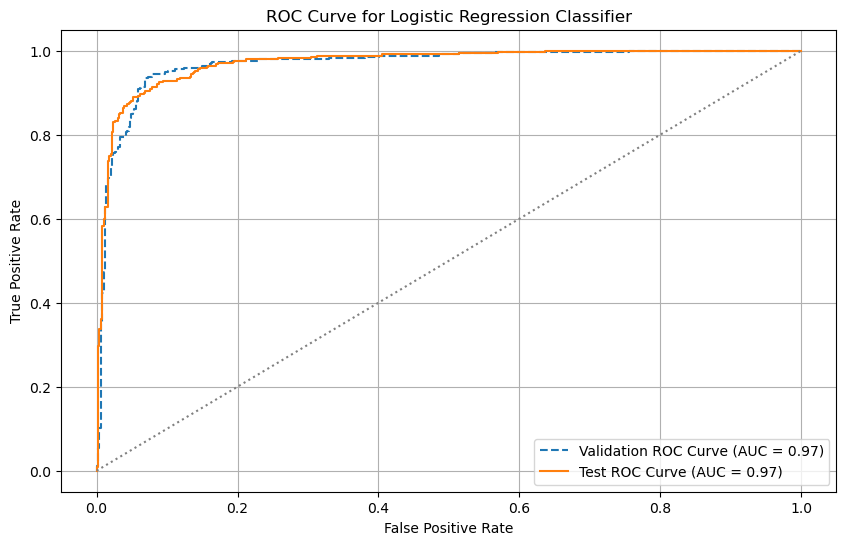

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_val_scores = best_model.decision_function(X_val)
y_test_scores = best_model.decision_function(X_test)

# Compute ROC curve & AUC for validation set
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_scores)
auc_val = auc(fpr_val, tpr_val)

# Compute ROC curve & AUC for test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_scores)
auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr_val, tpr_val, label=f'Validation ROC Curve (AUC = {auc_val:.2f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {auc_test:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Classifier')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

In [43]:
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

accuracy_val = accuracy_score(y_val, y_val_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

error_val = 1 - accuracy_val
error_test = 1 - accuracy_test

print(f'Validation Accuracy: {accuracy_val:.4f}, Prediction Error: {error_val:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}, Prediction Error: {error_test:.4f}')

Validation Accuracy: 0.9204, Prediction Error: 0.0796
Test Accuracy: 0.9216, Prediction Error: 0.0784
